In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 



# Fetching data

In [43]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Utils, plotting

In [51]:
def plot(title, x1, y1, label1 = None, title1 = None, 
         x2 = None, 
         y2 = None, 
         label2 = None, 
         title2 = None,
         mode1 = 'yo',
         mode2 = 'g^'):
    
    plt.plot(x1, y1, mode1, label = label1 if label1 is not None else '')
    if x2 is not None and y2 is not None:
        plt.plot(x2, y2, mode2, label = label2 if label2 is not None else '')
        
    plt.title(title)
    plt.xlabel(title1 if title1 is not None else '')
    plt.ylabel(title2 if title2 is not None else '')
    
    plt.legend()
    plt.show()
    
def plot3d(title, x1, y1, z1, x2 = None, y2 = None, z2 = None, label1 = None, label2 = None,
           xtitle=None, ytitle=None, ztitle=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1, y1, z1, c='red', label=label1 if label1 is not None else '')
    if x2 is not None and y2 is not None and z2 is not None:
        ax.scatter(x2, y2, z2, c='blue', marker='^',label=label2 if label2 is not None else '')
    ax.set_xlabel(xtitle if xtitle is not None else '')
    ax.set_ylabel(ytitle if ytitle is not None else '')
    ax.set_zlabel(ztitle if ztitle is not None else '')
    ax.set_title(title)
    ax.legend()
    plt.show()

def train_test_split(set1, set2, test_size, random_state=21):
    np.random.seed(random_state)
    indices = np.arange(len(set1))
    np.random.shuffle(indices)
    
    test_indices = indices[:int(test_size * len(set1))]
    train_indices = indices[int(test_size * len(set1)):]
    
    return set1[train_indices], set1[test_indices], set2[train_indices], set2[test_indices]


def normalisation(x_train__, x_test__):
    if isinstance(x_train__, pd.DataFrame):
        x_train__ = x_train__.values.tolist()
    if isinstance(x_test__, pd.DataFrame):
        x_test__ = x_test__.values.tolist()
    if isinstance(x_train__[0], float) or len(x_train__[0]) == 1:
        xmin = min(x_train__)
        xmax = max(x_train__)
        return ([(value - xmin) / (xmax - xmin) for value in x_train__],
                [(value - xmin) / (xmax - xmin) for value in x_test__], [xmin, xmax])
    
    if len(x_train__[0]) == 2:
        x_train__1 = [x[0] for x in x_train__]
        x_train__2 = [x[1] for x in x_train__]
        x_test__1 = [x[0] for x in x_test__]
        x_test__2 = [x[1] for x in x_test__]
        
        x_train_norm1, x_test_norm1, min_max1 = normalisation(x_train__1, x_test__1)
        x_train_norm2, x_test_norm2, min_max2 = normalisation(x_train__2, x_test__2)
        return list(zip(x_train_norm1, x_train_norm2)), list(zip(x_test_norm1, x_test_norm2)), [min_max1, min_max2]

# Logistic regressor

In [27]:
class LogisticRegression:
    def __init__(self, max_iter = 100, rate = 0.01, decision = 0.5):
        self.coef = []
        self.max_iter = max_iter
        self.intercept = 0
        self.rate = 0.01
        self.decision = decision
        
    def fit(self, x, y):
        self.coef = [np.random.random() for _ in range(len(x[0]) + 1)]
        for t in range(self.max_iter):
            for i in range(len(x)):
                for j in range(0, len(x[0])):
                    self.coef[j]= self.coef[j] - self.rate * (self.error(x[i]) - y[i]) * x[i][j]
                self.coef[len(x[0])] = self.coef[len(x[0])] - (self.error(x[i]) - y[i])
        self.intercept = self.coef[-1]
        self.coef = self.coef[:-1]

    def error(self, xi):
        result = self.coef[-1]
        for i in range(0, len(self.coef)):
            result += self.coef[i] * xi[i]
        
        return 1/(1 + np.exp(-result))

    def predict(self, x):
        return [self.error(xi) < self.decision for xi in x]

# Data

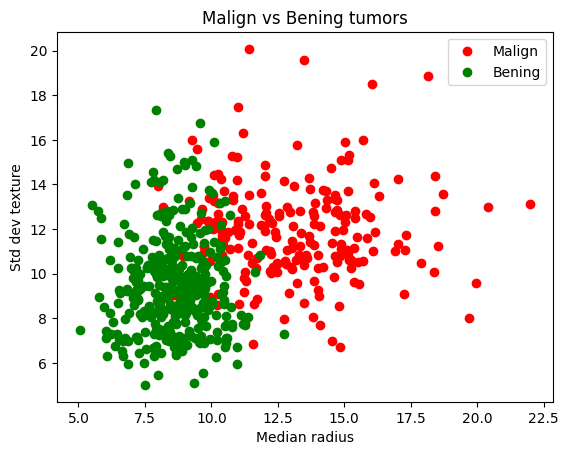

In [45]:
median_radius = [(x + y + z) / 3 for (x,y,z) in zip(X['radius1'], X['radius2'], X['radius3'])]
std_texture = [np.std([x, y, z]) for (x, y, z) in zip(X['texture1'], X['texture2'], X['texture3'])]

median_radius = list(median_radius)
std_texture = list(std_texture)
y = y.values

plot(title='Malign vs Bening tumors', 
     x1=[median_radius[i] for i in range(len(y)) if y[i] == 'M'], 
     y1=[std_texture[i] for i in range(len(y)) if y[i] == 'M'], 
     label1='Malign',
     x2=[median_radius[i] for i in range(len(y)) if y[i] == 'B'], 
     y2=[std_texture[i] for i in range(len(y)) if y[i] == 'B'], 
     label2='Bening', 
     title1='Median radius', 
     title2='Std dev texture', 
     mode1='ro', mode2='go')



# Train test split

In [52]:
median_radius_df = pd.Series(median_radius, name='median_radius')
std_texture_df = pd.Series(std_texture, name='std_texture')
data_df = pd.concat([median_radius_df, std_texture_df], axis=1)


x_train, x_test, y_train, y_test = train_test_split(data_df, y, test_size=0.2)

def plot_data(x, y, title):
    median_radius_train, std_texture_train = zip(*x)
    
    plot(title=title, 
         x1=[median_radius_train[i] for i in range(len(y)) if y[i] == 'M'], 
         y1=[std_texture_train[i] for i in range(len(y)) if y[i] == 'M'], 
         label1='Malign',
         x2=[median_radius_train[i] for i in range(len(y)) if y[i] == 'B'], 
         y2=[std_texture_train[i] for i in range(len(y)) if y[i] == 'B'], 
         label2='Bening', 
         title1='Median radius', 
         title2='Std dev texture', 
         mode1='ro', mode2='go')
    
plot_data(x_train, y_train, 'Malign vs Bening train data')
plot_data(x_test, y_test, 'Malign vs Bening test data')

KeyError: "None of [Index([172, 224, 252,  82,  88, 169, 525, 204, 332,  70,\n       ...\n       253, 428, 447, 202, 511, 419, 120, 368,  48, 207],\n      dtype='int64', length=456)] are in the [columns]"

# Data normalisation

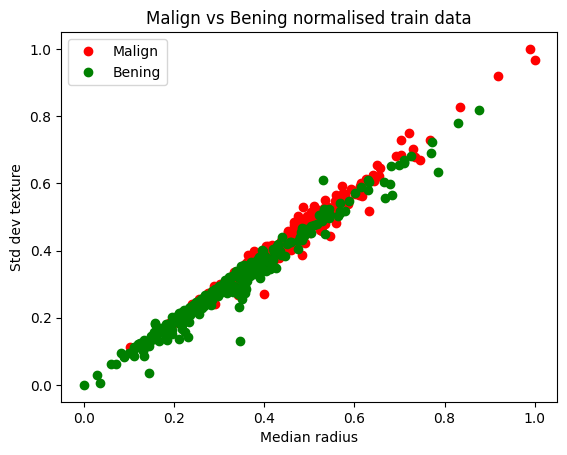

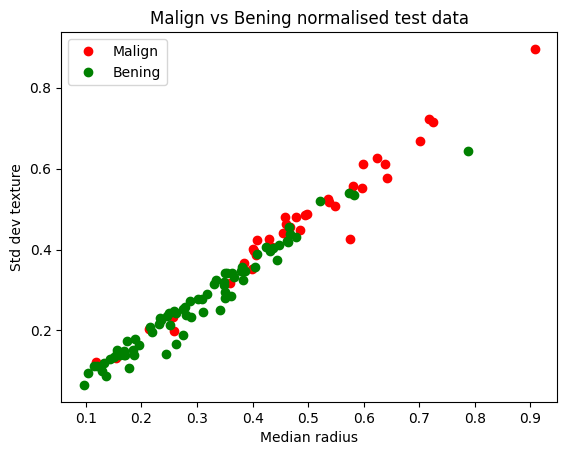

In [97]:
x_train_norm, x_test_norm, min_max_list = normalisation(x_train, x_test)

plot_data(x_train_norm, y_train, 'Malign vs Bening normalised train data')
plot_data(x_test_norm, y_test, 'Malign vs Bening normalised test data')

# Model training

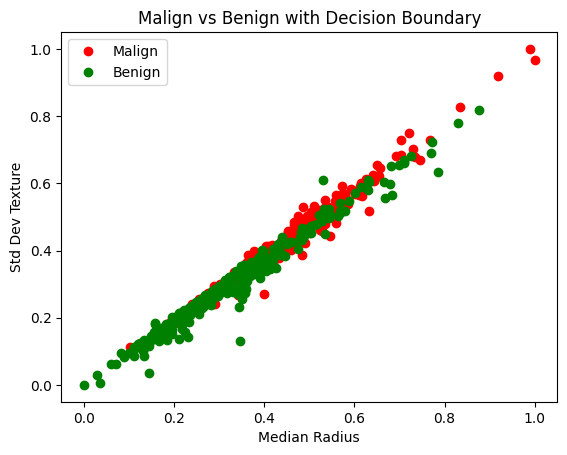

In [130]:
y_train = np.array(y_train)

model = LogisticRegression()
model.fit(x_train_norm, y_train)

w0 = model.intercept_[0]
w1 = model.coef_[0][0]
w2 = model.coef_[0][1]

median_radius_train, std_texture_train = zip(*x_train_norm)
median_radius_train = np.array(median_radius_train)
std_texture_train = np.array(std_texture_train)

# x_vals = np.linspace(min(median_radius_train), max(median_radius_train), 100)
# y_vals = (-w1 * x_vals - w0) / w2
# 
# plt.plot(
#     x_vals, y_vals,
#     'b-', label='Decision Boundary')

plot(title='Malign vs Benign with Decision Boundary',
    x1=median_radius_train[y_train == 'M'],
    y1=std_texture_train[y_train == 'M'],
    label1='Malign',
    x2=median_radius_train[y_train == 'B'],
    y2=std_texture_train[y_train == 'B'],
    label2='Benign',
    title1='Median Radius',
    title2='Std Dev Texture',
    mode1='ro',
    mode2='go')

# Predicted vs Actual

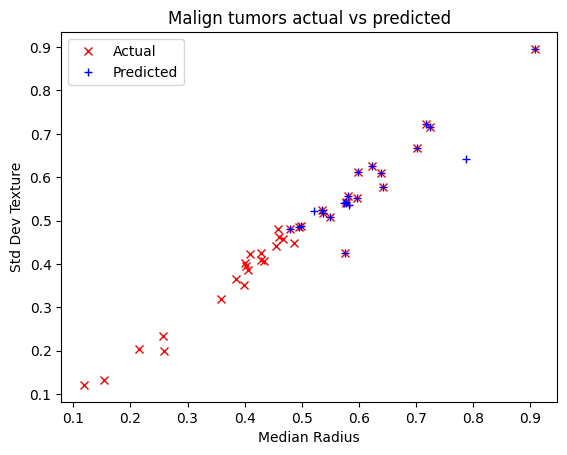

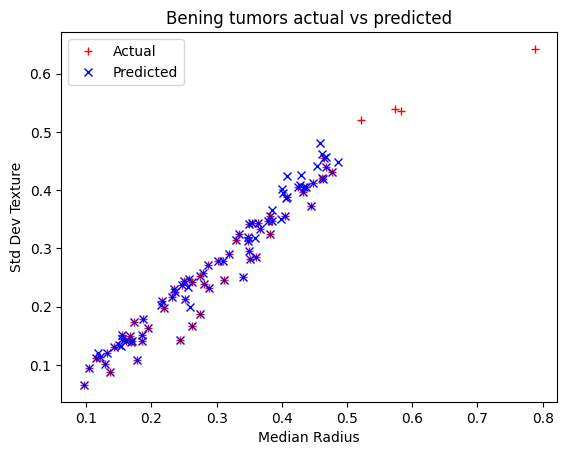

In [131]:
y_predict = model.predict(x_test_norm)

median_radius_test, std_texture_test = zip(*x_test_norm)

median_radius_test = np.array(median_radius_test)
std_texture_test = np.array(std_texture_test)
y_test = np.array(y_test)


plot(title='Malign tumors actual vs predicted',
    x1=median_radius_test[y_test == 'M'],
    y1=std_texture_test[y_test == 'M'],
    label1='Actual',
    x2=median_radius_test[y_predict == 'M'],
    y2=std_texture_test[y_predict == 'M'],
    label2='Predicted',
    title1='Median Radius',
    title2='Std Dev Texture',
    mode1='rx',
    mode2='b+')

plot(title='Bening tumors actual vs predicted',
    x1=median_radius_test[y_test == 'B'],
    y1=std_texture_test[y_test == 'B'],
    label1='Actual',
    x2=median_radius_test[y_predict == 'B'],
    y2=std_texture_test[y_predict == 'B'],
    label2='Predicted',
    title1='Median Radius',
    title2='Std Dev Texture',
    mode1='r+',
    mode2='bx')

# Texture = 10, radius = 18

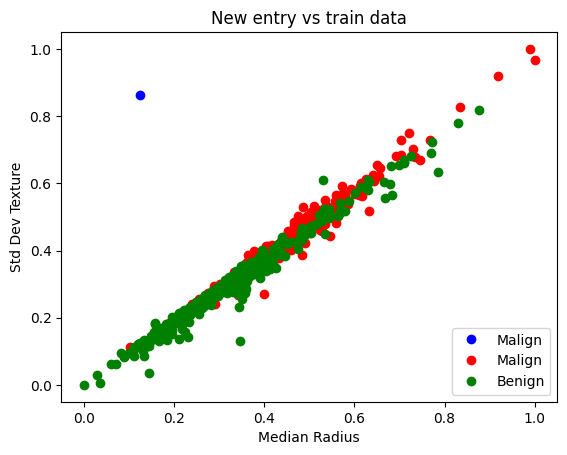

In [135]:
new_x_test = [[10, 18]]
texture_min_max, radius_min_max = min_max_list[0], min_max_list[1]

normalised_new_x_test = [[(x[0] - texture_min_max[0])/ (texture_min_max[1] - texture_min_max[0]),
                          (x[1] - radius_min_max[0]) / (radius_min_max[1] - radius_min_max[0])] for x in new_x_test ]

new_y_test = model.predict(normalised_new_x_test)

plt.plot(normalised_new_x_test[0][0], normalised_new_x_test[0][1], 'bo', label='Malign')
plt.legend()

plot(title='New entry vs train data',
    x1=median_radius_train[y_train == 'M'],
    y1=std_texture_train[y_train == 'M'],
    label1='Malign',
    x2=median_radius_train[y_train == 'B'],
    y2=std_texture_train[y_train == 'B'],
    label2='Benign',
    title1='Median Radius',
    title2='Std Dev Texture',
    mode1='ro',
    mode2='go')
